In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import csv
import os
import time
cwd = os.getcwd()
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)


def settings_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter='=')
        output = dict()
        for row in reader:
            output[row[0]] = row[1]
    return output


def csv_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if zeroth_row == True:
                row.remove('')
                row = [float(value) for value in row]
                data = np.array(row)
                zeroth_row = False
            else:
                row.remove('')
                new_row = [float(value) for value in row]
                data = np.vstack([data, new_row])
    return data


def mean_photons_calc(probabilities):
    photons = np.zeros(probabilities.shape[1])
    for i in range(photons.shape[0]):
        for j in range(probabilities.shape[0]):
            photons[i] = photons[i] + j * probabilities[j, i]
    return photons


def times_qload(folder_path):
    times_path = folder_path + '/times'
    times = qload(times_path)
    times = times / (2 * np.pi * 1000)
    return times


def above(x, y, trials):
    difference = y[:, :, np.newaxis] - divider(x, trials)
    above_yn = difference > 0
    return above_yn


class Parameters:
    def __init__(self, wc, wq, eps, g, chi, kappa, gamma, t_levels, c_levels):
        self.wc = wc
        self.wq = wq
        self.eps = eps
        self.g = g
        self.chi = chi
        self.gamma = gamma
        self.kappa = kappa
        self.t_levels = t_levels
        self.c_levels = c_levels

    def copy(self):
        params = Parameters(self.wc, self.wq, self.eps, self.g, self.chi, self.kappa, self.gamma, self.t_levels, self.c_levels)
        return params


class Results:
    def __init__(self, params=np.array([]), wd_points=np.array([]),
                 transmissions=np.array([]), edge_occupations_c=np.array([]), edge_occupations_t=np.array([])):
        self.params = params
        self.wd_points = wd_points
        self.transmissions = transmissions
        self.edge_occupations_c = edge_occupations_c
        self.edge_occupations_t = edge_occupations_t
        self.abs_transmissions = np.absolute(self.transmissions)
        self.size = self.wd_points.size

    def concatenate(self, results):
        combined_params = np.concatenate([self.params, results.params])
        combined_wd_points = np.concatenate([self.wd_points, results.wd_points])
        combined_transmissions = np.concatenate([self.transmissions, results.transmissions])
        combined_edge_occupations_c = np.concatenate([self.edge_occupations_c, results.edge_occupations_c])
        combined_edge_occupations_t = np.concatenate([self.edge_occupations_t, results.edge_occupations_t])
        sort_indices = np.argsort(combined_wd_points)
        combined_params = combined_params[sort_indices]
        combined_wd_points = combined_wd_points[sort_indices]
        combined_transmissions = combined_transmissions[sort_indices]
        combined_edge_occupations_c = combined_edge_occupations_c[sort_indices]
        combined_edge_occupations_t = combined_edge_occupations_t[sort_indices]
        combined_results = Results(combined_params, combined_wd_points,
                                   combined_transmissions, combined_edge_occupations_c, combined_edge_occupations_t)
        return combined_results

    def delete(self, indices):
        reduced_params = np.delete(self.params, indices)
        reduced_wd_points = np.delete(self.wd_points, indices)
        reduced_transmissions = np.delete(self.transmissions, indices)
        reduced_edge_occupations_c = np.delete(self.edge_occupations_c, indices)
        reduced_edge_occupations_t = np.delete(self.edge_occupations_t, indices)
        reduced_results = Results(reduced_params, reduced_wd_points,
                                  reduced_transmissions, reduced_edge_occupations_c, reduced_edge_occupations_t)
        params_change = (reduced_params == self.params)
        wd_points_change = (reduced_wd_points == self.wd_points)
        transmissions_change = (reduced_transmissions == self.transmissions)
        edge_occupations_c_change = (reduced_edge_occupations_c == self.edge_occupations_c)
        edge_occupations_t_change = (reduced_edge_occupations_t == self.edge_occupations_t)
        print np.all([params_change, wd_points_change, transmissions_change, edge_occupations_c_change, edge_occupations_t_change])
        return reduced_results

    def queue(self):
        queue = Queue(self.params, self.wd_points)
        return queue


def fidelity_calc(set1, set2, trials):
    
    set1_above = np.sum(above(set1[0, :, :], set1[1, :, :], trials), axis=0)
    set1_total = set1.shape[1]
    set1_above_fraction = 1.0 * set1_above / set1_total
  
    set2_above = np.sum(above(set2[0, :, :], set2[1, :, :], trials), axis=0)
    set2_total = set2.shape[1]
    set2_above_fraction = 1.0 * set2_above / set2_total
       
    fidelity = 0.5 * (1 + np.abs(set1_above_fraction - set2_above_fraction))
    
    return fidelity


def initial_parameters_calc(set1, set2):
    set1_mean = np.mean(set1, axis=1)
    set2_mean = np.mean(set2, axis=1)
    midpoint = np.mean(np.array([set1_mean, set2_mean]), axis = 0)
    difference = set2_mean - set1_mean
    grad = difference[1] / difference[0]
    theta = np.arctan(-1 / grad)    
    return np.array([theta, midpoint[0], midpoint[1]]), difference


def divider(x, trials):
    y = (x[:, :, np.newaxis] - trials[1, np.newaxis, :, :]) * np.tan(trials[0, np.newaxis, :, :]) + trials[2, np.newaxis, :, :]
    return y
#traj, trial
#now traj, trial, timeslice
#trials feed in as parameter, timeslice, trial
#out traj, timeslice, trial
#x in traj, timeslice


def best_guess(set1, set2, trials):
    fidelities = fidelity_calc(set1, set2, trials)
    max_idx = np.argmax(fidelities, axis=1)
    best = np.zeros([3, max_idx.shape[0]])
    for i, j in enumerate(max_idx):
        best[:, i] = trials[:, i, j]
    return best

    
def new_trials(initial_trial, param_idx, region, points):
    trials = np.zeros([3, region.shape[0], points])
    for idx, reg in enumerate(region):
        trials[param_idx, idx, :] = np.linspace(-reg/2, reg/2, points)
    trials = trials + initial_trial[:, :, np.newaxis]
    return trials


def optimize(set1, set2):

    initial_trials, differences = initial_parameters_calc(set1, set2)
    theta_range = np.pi * np.ones([set1.shape[2]])
    x_range = np.linalg.norm(differences, axis=0)
    y_range = np.linalg.norm(differences, axis=0)
    n_trials = 99
    n_iterations = 5
    refinement = 1.2
    best_trials = initial_trials
    
    for idx in range(n_iterations):
        trials = new_trials(best_trials, 0, theta_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        trials = new_trials(best_trials, 1, x_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        trials = new_trials(best_trials, 2, y_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        theta_range = theta_range / refinement
        x_range = x_range / refinement
        y_range = y_range / refinement
    
    best_fidelities = fidelity_calc(set1, set2, best_trials[:, :, np.newaxis])
    
    return best_fidelities, best_trials
    


In [2]:
def reinitialize(sweep):
    new_sweep = Sweep()
    new_sweep.sweep = sweep.sweep
    new_sweep.spectrum = sweep.spectrum
    new_sweep.inventory()
    return new_sweep

class Run:
    def __init__(self):
        self.diff_d_I = None
        self.diff_d_Q = None
        self.diff_d_p = None
        self.diff_d_mp = None
        self.diff_u_I = None
        self.diff_u_Q = None
        self.diff_u_p = None
        self.diff_u_mp = None
        self.master_d_p = None
        self.master_d_mp = None
        self.master_u_p = None
        self.master_u_mp = None
        self.steady_state = None
        self.fidelities = None
        self.divide_params = None
        self.fidelity_times = None
        self.unint_fidelities = None
        self.unint_divide_params = None
        self.diff_d_I_m = None
        self.diff_d_Q_m = None
        self.diff_u_I_m = None
        self.diff_u_Q_m = None
        self.diff_d_mag = None
        self.diff_d_phase = None
        self.diff_u_mag = None
        self.diff_u_phase = None 
        self.diff_sep_I = None
        self.diff_sep_Q = None
        self.diff_sep_mag = None
        self.diff_sep_phase = None
        self.diff_sep_mag_sq = None
        self.diff_times = None
        self.master_times = None
        


def sweep_load(directory, dp=4, update=False, fidelity_calc=True):
    
    if os.path.isfile(directory + '/sweep_data.npy') and not update:
        sweep_data = np.load(directory + '/sweep_data.npy')[()]
        sweep_class = Sweep()
        sweep_class.sweep = sweep_data[0]
        sweep_class.spectrum = sweep_data[1]
        sweep_class.inventory()
        return sweep_class
    
    sweep = dict()
    
    subdir = directory + '/master/down'
    if os.path.isdir(subdir):
        bottom_levels = []
        for idx, (dirpath, dirnames, filenames) in enumerate(os.walk(subdir)):
            if not dirnames:
                bottom_levels.append(dirpath)
        for path in bottom_levels:
            master_down = qload(path + '/expectations')   
            for key in master_down:
                r_key = round(key, dp)
                if r_key not in sweep:
                    sweep[r_key] = Run()
                sweep[r_key].master_d_p = master_down[key]
                sweep[r_key].master_d_mp = mean_photons_calc(sweep[r_key].master_d_p)
                if sweep[r_key].master_times is None:
                    sweep[r_key].master_times = times_qload(path) 
    
    
    subdir = directory + '/master/up'
    if os.path.isdir(subdir):
        bottom_levels = []
        for idx, (dirpath, dirnames, filenames) in enumerate(os.walk(subdir)):
            if not dirnames:
                bottom_levels.append(dirpath)
        for path in bottom_levels:
            master_up = qload(path + '/expectations')
            times = times_qload(path)  
            for key in master_up:
                r_key = round(key, dp)
                if r_key not in sweep:
                    sweep[r_key] = Run()
                sweep[r_key].master_u_p = master_up[key]
                sweep[r_key].master_u_mp = mean_photons_calc(sweep[r_key].master_u_p)
                if sweep[r_key].master_times is None:
                    sweep[r_key].master_times = times_qload(path) 
    
    
    subdir = directory + '/steady_state'
    if os.path.isdir(subdir):
        bottom_levels = []
        for idx, (dirpath, dirnames, filenames) in enumerate(os.walk(subdir)):
            if not dirnames:
                bottom_levels.append(dirpath)
        for path in bottom_levels:
            steady_states = qload(path + '/density_matrix')
            for key in steady_states:
                r_key = round(key, dp)
                if r_key not in sweep:
                    sweep[r_key] = Run()
                sweep[r_key].steady_state = steady_states[key]
    
    
    subdir = directory + '/spectroscopy'
    if os.path.isdir(subdir):
        spectrum = None
        bottom_levels = []
        for idx, (dirpath, dirnames, filenames) in enumerate(os.walk(subdir)):
            if not dirnames:
                bottom_levels.append(dirpath)
        for path in bottom_levels:
            spec_results = qload(path + '/spectroscopy')
            spec_keys = spec_results.keys()
            if spectrum:
                spectrum = spectrum.concatenate(spec_results[spec_keys[0]])
            else:
                spectrum = spec_results[spec_keys[0]]
    
    subdir = directory + '/diffusive/down'
    if os.path.isdir(subdir):
        bottom_levels = []
        for idx, (dirpath, dirnames, filenames) in enumerate(os.walk(subdir)):
            if not dirnames:
                bottom_levels.append(dirpath)
        n_dirs = len(bottom_levels)      
        for idx, run in enumerate(bottom_levels):
            print "Down progress = " + str(1.0*idx/n_dirs)
            settings_path = run + '/settings.cfg'
            settings = settings_load(settings_path)
            drive_frequency = float(settings['omega_d'])
            drive_frequency = round(drive_frequency, dp)
            endtime = float(settings['endtime'])
            snapshots = float(settings['snapshots_number'])
            timestep = endtime / snapshots
            if drive_frequency not in sweep:
                sweep[drive_frequency] = Run()
            I_path = run + '/ReaverageAlpha9.dat'
            Q_path = run + '/ImaverageAlpha9.dat'
            p_path = run + '/photons9.dat'
            sweep[drive_frequency].diff_d_I = csv_load(I_path)
            sweep[drive_frequency].diff_d_Q = csv_load(Q_path)
            sweep[drive_frequency].diff_d_p = csv_load(p_path)
            sweep[drive_frequency].diff_d_mp = np.mean(sweep[drive_frequency].diff_d_p, axis=0)
            if sweep[drive_frequency].diff_times is None:
                sweep[drive_frequency].diff_times = np.linspace(0, endtime - timestep, snapshots)
    
   
    subdir = directory + '/diffusive/up'
    if os.path.isdir(subdir):
        bottom_levels = []
        for idx, (dirpath, dirnames, filenames) in enumerate(os.walk(subdir)):
            if not dirnames:
                bottom_levels.append(dirpath)
        n_dirs = len(bottom_levels)      
        for idx, run in enumerate(bottom_levels):
            print "Up progress = " + str(1.0*idx/n_dirs)
            settings_path = run + '/settings.cfg'
            settings = settings_load(settings_path)
            drive_frequency = float(settings['omega_d'])
            drive_frequency = round(drive_frequency, dp)
            endtime = float(settings['endtime'])
            snapshots = float(settings['snapshots_number'])
            timestep = endtime / snapshots
            if drive_frequency not in sweep:
                 sweep[drive_frequency] = Run()
            I_path = run + '/ReaverageAlpha9.dat'
            Q_path = run + '/ImaverageAlpha9.dat'
            p_path = run + '/photons9.dat'
            sweep[drive_frequency].diff_u_I = csv_load(I_path)
            sweep[drive_frequency].diff_u_Q = csv_load(Q_path)
            sweep[drive_frequency].diff_u_p = csv_load(p_path)
            sweep[drive_frequency].diff_u_mp = np.mean(sweep[drive_frequency].diff_u_p, axis=0)
            if sweep[drive_frequency].diff_times is None:
                sweep[drive_frequency].diff_times = np.linspace(0, endtime - timestep, snapshots)
    
    sweep_instance = Sweep()
    sweep_instance.sweep = sweep
    sweep_instance.spectrum = spectrum
    sweep_instance.alpha_calc()
    sweep_instance.inventory()
    if fidelity_calc:
        sweep_instance.fidelity_calc()
    sweep_instance.save(directory)
        
    return sweep_instance


class Sweep:
    def __init__(self):
        self.sweep = None
        self.spectrum = None
        self.freqs_diff_u = []
        self.freqs_diff_d = []
        self.freqs_master_d = []
        self.freqs_master_u = []
        self.freqs_steady_state = []
        
    def update(self, new_sweep):
        assert np.all(self.times == new_sweep.times), "Data points are taken at different times!"
        self.sweep.update(new_sweep.sweep)
        
    def plot(self, window=None, col3='fidelities'):
        valid_freqs = []
        for freq, run in self.sweep.iteritems():
            if run.diff_d_I is not None and run.diff_u_I is not None and run.master_d_p is not None and run.master_u_p is not None:
                valid_freqs.append(freq)
        
        valid_freqs = sorted(valid_freqs)
        if window is not None:
            valid_freqs = valid_freqs[window[0]:min(window[1], len(valid_freqs))]
        rows = len(valid_freqs)
        fontsize = 17
        width = 0.9
        labelsize = 22
        columns = 3
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        font = {'family' : 'normal',
                'size'   : 20}
        plt.rc('font', **font)
        pylab.rcParams['figure.figsize'] = (30, 25 * rows)
        
        for idx, freq in enumerate(valid_freqs):
            plt.subplot(columns * rows, columns, 1 + columns * idx)
            plt.scatter(self.spectrum.wd_points, self.spectrum.abs_transmissions)
            plt.title('Drive frequency = ' + str(freq) + ' GHz')
            plt.xlabel('Drive frequency / GHz')
            plt.ylabel(r'$\langle$ a $\rangle$')
            plt.xlim([np.min(self.spectrum.wd_points), np.max(self.spectrum.wd_points)])
            plt.axvline(x=freq, ymin=0.0, ymax = 3.0, linewidth=2, color='k')
            plt.tick_params(axis='both', labelsize=labelsize)
            
            plt.subplot(rows*columns, columns, columns*idx + 2)
            plt.plot(self.sweep[freq].master_times, self.sweep[freq].master_d_mp, color='b', ls='--')
            plt.plot(self.sweep[freq].master_times, self.sweep[freq].master_u_mp, color='r', ls='--')
            plt.plot(self.sweep[freq].diff_times, self.sweep[freq].diff_d_mp, color='b')
            plt.plot(self.sweep[freq].diff_times, self.sweep[freq].diff_u_mp, color='r')
            legend = [r'$| g \rangle$ master eq', r'$| e \rangle$ master eq', r'$| g \rangle$ diffusive SSE', r'$| e \rangle$ diffusive SSE']
            if idx == 0:
                plt.legend(legend, loc=4)
            plt.xlabel(r'Time / $\mu$s')
            plt.ylabel(r'Photons $\langle$ n $\rangle$')
            plt.tick_params(axis='both')
            plt.title('Transient response of the cavity')
            plt.tick_params(axis='both', labelsize=labelsize)
            
            if col3 == 'fidelities':
                plt.subplot(rows*columns, columns, 3 + columns*idx)
                plt.plot(self.sweep[freq].fidelity_times, self.sweep[freq].fidelities)
                plt.title('Fidelity with which integrated IQ distributions can be distinguished')
                plt.ylabel('Fidelity')
                plt.xlabel(r'Time /$\mu$s')
                plt.tick_params(axis='both', labelsize=labelsize)
            elif col3 == 'unint_fidelities':
                plt.subplot(rows*columns, columns, 3 + columns*idx)
                plt.plot(self.sweep[freq].fidelity_times, self.sweep[freq].unint_fidelities)
                plt.title('Fidelity with which unintegrated IQ distributions can be distinguished')
                plt.ylabel('Fidelity')
                plt.xlabel(r'Time /$\mu$s')
                plt.tick_params(axis='both', labelsize=labelsize)
            elif col3 == 'steady_states':
                plt.subplot(rows*columns, columns, 3 + columns*idx)
                rho_c_ss = self.sweep[freq].steady_state.ptrace(0)
                c_occupations = rho_c_ss.diag()
                labels = np.arange(c_occupations.size)
                plt.bar(labels - width / 2, c_occupations, width, color='r')
                plt.xlim([-0.5, c_occupations.size - 0.5])
                plt.title('Steady state cavity occupations')
                plt.xlabel('Cavity level')
                plt.ylabel('Probability')
                plt.tick_params(axis='both', labelsize=labelsize)
                
    def plot_readout(self, window=None):
        valid_freqs = []
        for freq, run in self.sweep.iteritems():
            if run.diff_sep_mag is not None and run.fidelities is not None:
                 valid_freqs.append(freq)
        
        valid_freqs = sorted(valid_freqs)
        if window is not None:
            valid_freqs = valid_freqs[window[0]:min(window[1], len(valid_freqs))]
        rows = len(valid_freqs)
        fontsize = 17
        width = 0.9
        labelsize = 22
        columns = 3
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        font = {'family' : 'normal',
                'size'   : 20}
        plt.rc('font', **font)
        pylab.rcParams['figure.figsize'] = (30, 25 * rows)
    
        for idx, freq in enumerate(valid_freqs):
            plt.subplot(columns * rows, columns, 1 + columns * idx)
            plt.scatter(self.spectrum.wd_points, self.spectrum.abs_transmissions)
            plt.title('Drive frequency = ' + str(freq) + ' GHz')
            plt.xlabel('Drive frequency / GHz')
            plt.ylabel(r'$|\langle$ a $\rangle|$')
            plt.xlim([np.min(self.spectrum.wd_points), np.max(self.spectrum.wd_points)])
            plt.axvline(x=freq, ymin=0.0, ymax=3.0, linewidth=2, color='k')
            plt.tick_params(axis='both', labelsize=labelsize)

            plt.subplot(rows*columns, columns, columns*idx + 2)
            n_times = self.times.shape[0]
            plt.plot(self.sweep[freq].diff_times, self.sweep[freq].diff_sep_mag_sq, color='r')    
            plt.xlabel(r'Time / $\mu$s')
            plt.ylabel(r'S(t)')
            plt.tick_params(axis='both', labelsize=labelsize)
            plt.title(r'Separation')

            plt.subplot(rows*columns, columns, 3 + columns*idx)
            plt.plot(self.sweep[freq].fidelity_times, self.sweep[freq].fidelities)
            plt.title('Fidelity')
            plt.ylabel('F(t)')
            plt.xlabel(r'Time /$\mu$s')
            plt.tick_params(axis='both', labelsize=labelsize)
            
    def save(self, directory):
        data = [self.sweep, self.spectrum]
        np.save(directory + '/sweep_data.npy', data)
        
    def fidelity_calc(self, integrated=True, unintegrated=False):
        start_time = time.time()
        sparsify = 20
        shared_keys = []
        for freq, run in self.sweep.iteritems():
            if run.diff_d_I is not None and run.diff_u_I is not None:
                shared_keys.append(freq)
    
        for idx, freq in enumerate(shared_keys):
            I_u = self.sweep[freq].diff_u_I
            Q_u = self.sweep[freq].diff_u_Q
            I_d = self.sweep[freq].diff_d_I
            Q_d = self.sweep[freq].diff_d_Q
            
            if integrated == True:
                I_u_int = np.cumsum(I_u, axis=1)
                Q_u_int = np.cumsum(Q_u, axis=1)
                I_d_int = np.cumsum(I_d, axis=1)
                Q_d_int = np.cumsum(Q_d, axis=1)
    
                set1 = np.array([I_u_int[:,1::sparsify], Q_u_int[:,1::sparsify]])
                set2 = np.array([I_d_int[:,1::sparsify], Q_d_int[:,1::sparsify]])
                fidelity_times = self.sweep[freq].diff_times[1::sparsify]
                self.sweep[freq].fidelity_times = fidelity_times        
                self.sweep[freq].fidelities, self.sweep[freq].divide_params = optimize(set1, set2)
                
            if unintegrated == True:
                set1 = np.array([I_u[:,1::sparsify], Q_u[:,1::sparsify]])
                set2 = np.array([I_d[:,1::sparsify], Q_d[:,1::sparsify]])
                fidelity_times = self.sweep[freq].diff_times[1::sparsify]
                self.sweep[freq].fidelity_times = fidelity_times        
                self.sweep[freq].unint_fidelities, self.sweep[freq].unint_divide_params = optimize(set1, set2)
            
            print "Fidelity progress = " + str((1.0*idx)/len(shared_keys))
            
        elapsed_time = time.time() - start_time
        print "Fidelity calculation took " + str(elapsed_time) + " seconds."
        
    def alpha_calc(self):
        for freq, run in self.sweep.iteritems():
            if run.diff_d_I is not None and run.diff_u_I is not None:
                run.diff_d_I_m = np.mean(run.diff_d_I, axis=0)
                run.diff_d_Q_m = np.mean(run.diff_d_Q, axis=0)
                run.diff_u_I_m = np.mean(run.diff_u_I, axis=0)
                run.diff_u_Q_m = np.mean(run.diff_u_Q, axis=0)
                
                run.diff_d_mag = np.linalg.norm(np.vstack([run.diff_d_I_m, run.diff_d_Q_m]), axis=0)
                run.diff_u_mag = np.linalg.norm(np.vstack([run.diff_u_I_m, run.diff_u_Q_m]), axis=0)
                run.diff_d_phase = np.arctan2(run.diff_d_Q_m, run.diff_d_I_m)
                run.diff_u_phase = np.arctan2(run.diff_u_Q_m, run.diff_u_I_m)
                
                run.diff_sep_I = run.diff_u_I_m - run.diff_d_I_m
                run.diff_sep_Q = run.diff_u_Q_m - run.diff_d_Q_m
                
                run.diff_sep_mag = np.linalg.norm(np.vstack([run.diff_sep_I, run.diff_sep_Q]), axis=0)
                run.diff_sep_mag_sq = np.power(run.diff_sep_mag, 2)
                run.diff_sep_phase = np.arctan2(run.diff_sep_Q, run.diff_sep_I)
    
    def inventory(self):
        for freq, run in sorted(self.sweep.iteritems()):
            if run.diff_u_I is not None:
                self.freqs_diff_u.append(freq)
            if run.diff_d_I is not None:
                self.freqs_diff_d.append(freq)
            if run.master_u_p is not None:
                self.freqs_master_u.append(freq)
            if run.master_d_p is not None:
                self.freqs_master_d.append(freq)
            if run.steady_state is not None:
                self.freqs_steady_state.append(freq)

In [12]:
sweep = sweep_load('./sweep', update=True)

Loaded dict object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded dict object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded dict object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray objec

/homes/pbrookes/.local/lib/python2.7/site-packages/ipykernel/__main__.py:151: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


Down progress = 0.0222222222222
Down progress = 0.0444444444444
Down progress = 0.0666666666667
Down progress = 0.0888888888889
Down progress = 0.111111111111
Down progress = 0.133333333333
Down progress = 0.155555555556
Down progress = 0.177777777778
Down progress = 0.2
Down progress = 0.222222222222
Down progress = 0.244444444444
Down progress = 0.266666666667
Down progress = 0.288888888889
Down progress = 0.311111111111
Down progress = 0.333333333333
Down progress = 0.355555555556
Down progress = 0.377777777778
Down progress = 0.4
Down progress = 0.422222222222
Down progress = 0.444444444444
Down progress = 0.466666666667
Down progress = 0.488888888889
Down progress = 0.511111111111
Down progress = 0.533333333333
Down progress = 0.555555555556
Down progress = 0.577777777778
Down progress = 0.6
Down progress = 0.622222222222
Down progress = 0.644444444444
Down progress = 0.666666666667
Down progress = 0.688888888889
Down progress = 0.711111111111
Down progress = 0.733333333333
Down p

In [9]:
sweep.sweep[10.495].master_u_p

The parameters of the system are given below:

In [ ]:
directory = cwd + '/sweep_0.2MHz/steady_state'
subdirs = [x[0] for x in os.walk(directory)]
del subdirs[0]
params = qload(subdirs[0] + '/params')
print "Transmon levels = " + str(params.t_levels)
print "Cavity levels = " + str(params.c_levels)
print "Bare cavity resonance f_c = " + str(params.wc) + " GHz"
print "Qubit transition f_01 = " + str(params.wq) + " GHz"
print "Cavity decay rate \kappa = " + str(params.kappa) + " GHz"
print "Qubit relaxation rate \gamma = " + str(params.gamma) + " GHz"
print "Coupling g = " + str(params.g) + " GHz"
print "Drive \epsilon = " + str(params.eps) + " GHz"

Below we can see two grids of graphs showing the transient response of the qubit-cavity system for a range of drive frequencies around resonance.

In [ ]:
sweep.plot(window=[0, 10],col3='steady_states')

In [ ]:
sweep.plot(window=[10, 26],col3='steady_states')

In an experimental readout protocol we would be applying a drive frequency to the cavity and then measuring the transmitted signal using homodyne detection. The components are labelled I and Q respectively. The transmitted signal can be split into in components which are in-phase and out-of-phase with the drive.

In order to figure out what parameters (drive frequency, drive amplitude, etc) would give a good readout protocol we can use trajectory simulations. Trajectory simulations allow us to produce an ensemble of points in the IQ plane each corresponding to the possible outcome of an experimental run.

We are searching for a set of experimental parameters which will produce a good readout protocol. If we start the qubit in two orthogonal initial states such as $|e\rangle$ and $|g\rangle$ then the resulting IQ ensembles will be easily distinguishable.

We therefore define two quantities which will help us judge the distinguishability of two IQ ensembles. These are separation and fidelity, denoted by S and F respectively.

The separation between two IQ distributions is given by the distance between their "centres of mass". Mathematically it is defined by $S_{\psi,\phi}(t) = |tr\big(\rho_\psi(t) - \rho_\phi(t))a\big)|^2$ where $\rho_\psi(t)$ is the state of the qubit-cavity system at time $t$ after being initialized in state $\psi$. For our purposes we will be studying how the transient response of the system varies when we initialise the qubit in either the ground or the excited state. Ie we take $|\psi\rangle = |g\rangle_q \otimes |0\rangle_c$ and $|\phi> = |e\rangle_q \otimes |0\rangle_c$.

Fidelity is the distinguishability of two IQ ensembles by drawing a straight line in the IQ plane to divide them. It is given by the probability that the ensmble to which a point belongs can be correctly identified by the side of the line on which it is found. If all points in the first distribution lie on one side of the line and all points of the second distribution lie on the other side then we have a fidelity of $F=1$. The lowest possible fidelity is $F=0.5$ corresponding to a readout protocol no better than randomly guessing the state.

AttributeError: 'NoneType' object has no attribute 'wd_points'

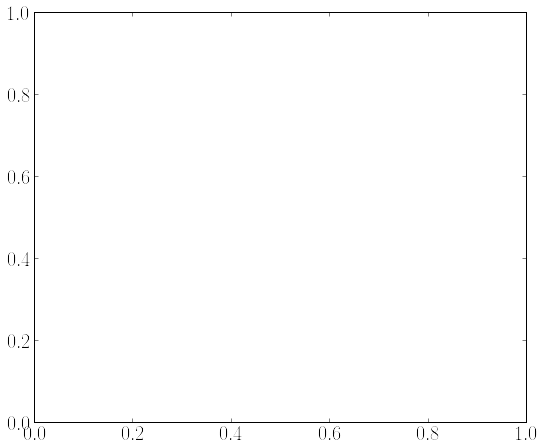

In [11]:
sweep.plot_readout(window=[0,10])

In [ ]:
sweep.plot_readout(window=[10,26])

In [ ]:
a = np.ones(3)

In [ ]:
a = None

In [ ]:
if a is None:
    print "hello"

In [ ]:
ls

In [ ]:
ls control

In [ ]:
os.walk('./diffusive', topdown=False)

In [ ]:
paths = [x[0] for x in os.walk('./control/diffusive')]

In [ ]:
paths

In [ ]:
bottom_levels = []
for dirpath, dirnames, filenames in os.walk('./control/diffusive'):
    if not dirnames:
        bottom_levels.append(dirpath)

In [ ]:
bottom_levels